## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [2]:
# pluto = gpd.read_file("../Data/nyc_mappluto_24v1_1_shp/MapPLUTO.shp")

In [8]:
pluto_ogrio = ogr.read_dataframe (r"C:\Users\cathe\Documents\Github\cdp-mapping-systems\Data\New folder\geo_export_a58da130-93f8-48ac-b678-13005fcb5c2f.shp")

# basic exploration


In [9]:
pluto_ogrio.columns

Index(['school_dis', 'shape_area', 'shape_leng', 'geometry'], dtype='object')

In [10]:
pluto_ogrio.dtypes

school_dis     float64
shape_area     float64
shape_leng     float64
geometry      geometry
dtype: object

## categorical column


In [53]:
pluto_ogrio.geometry.value_counts()

geometry
MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...    1
POLYGON ((-73.95672 40.78660, -73.95716 40.785...    1
MULTIPOLYGON (((-73.91990 40.59960, -73.91996 ...    1
POLYGON ((-73.97906 40.70595, -73.97924 40.705...    1
POLYGON ((-73.93312 40.69579, -73.93237 40.695...    1
POLYGON ((-73.91181 40.70343, -73.91290 40.702...    1
POLYGON ((-73.97177 40.72582, -73.97179 40.725...    1
POLYGON ((-73.88284 40.84782, -73.88200 40.847...    1
POLYGON ((-73.98633 40.69105, -73.98536 40.690...    1
POLYGON ((-73.92044 40.66563, -73.92061 40.665...    1
POLYGON ((-73.95440 40.73911, -73.95428 40.739...    1
MULTIPOLYGON (((-73.92137 40.66549, -73.92143 ...    1
MULTIPOLYGON (((-73.74461 40.77895, -73.74429 ...    1
POLYGON ((-73.73816 40.72896, -73.73716 40.728...    1
POLYGON ((-73.84485 40.73575, -73.84480 40.735...    1
MULTIPOLYGON (((-73.92134 40.80085, -73.92114 ...    1
MULTIPOLYGON (((-73.84674 40.60485, -73.84672 ...    1
MULTIPOLYGON (((-73.83193 40.59345, -73.83117 ...    1
M

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [18]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land",
}

In [22]:
pluto_ogrio["LandUse"] = pluto_ogrio.shape_area.map(land_use_codes)

## Your turn:

- How many lots of each land use type are there?
  - Use `groupby` to determine the number of lots of each land use type
- What is the lot area of each land use type?
  - Use `groupby` to make a bar chart that shows the average lot area of each land use type
- Can you find the total number of lots that contain `Commercial & Office Buildings` in the Bronx?
  - use groupby on multiple columns to achieve this
- Can you find the share of each land use type in each borough?


In [23]:
pluto_ogrio.groupby(["LandUse", "shape_area"])


## Okay, now let's look at lot and building area


IndexError: index 0 is out of bounds for axis 0 with size 0

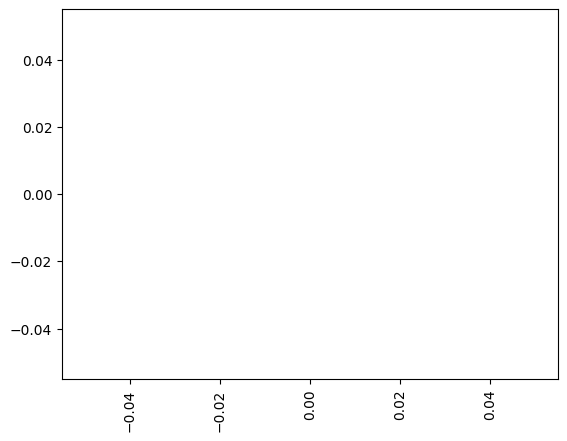

In [26]:
pluto_ogrio.groupby("LandUse").shape_area.sum().sort_values(ascending=False).plot.bar()
plt.title("Total lot area by land use type")

IndexError: index 0 is out of bounds for axis 0 with size 0

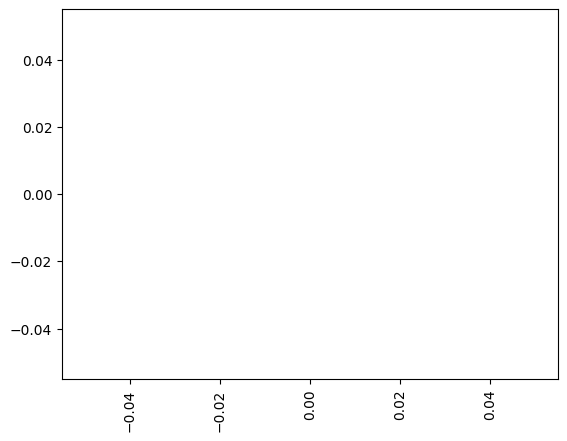

In [27]:
# now the same but for building area
pluto_ogrio.groupby("LandUse").shape_area.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

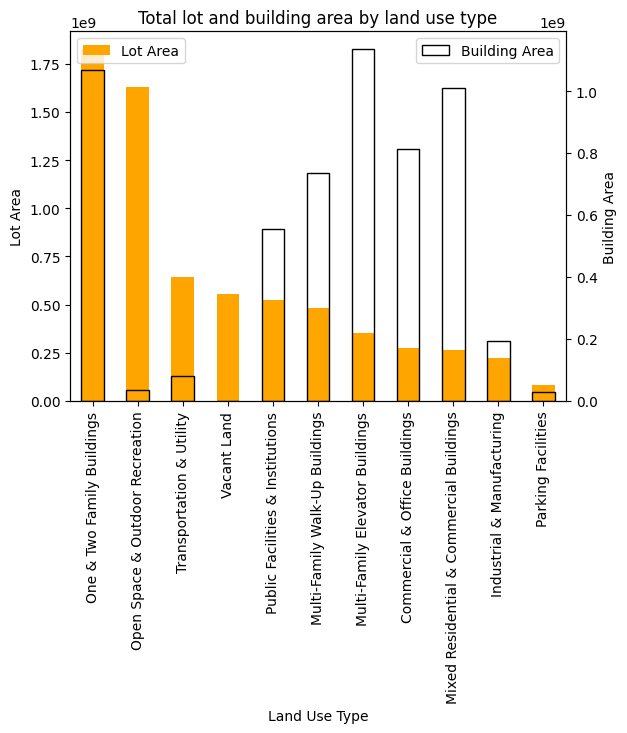

In [12]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [28]:
pluto_ogrio.shape_area.unique()

array([1.75191726e+08, 1.13412691e+08, 3.85611567e+08, 1.04871083e+08,
       4.67637989e+07, 5.18983181e+07, 3.51604678e+07, 6.90893587e+07,
       1.96154192e+08, 1.28440515e+08, 1.50290387e+08, 4.74014330e+07,
       4.24301106e+08, 4.20205351e+08, 2.47506433e+08, 5.26155816e+07,
       1.99876478e+08, 7.90724992e+08, 1.60415475e+09, 2.58761330e+08,
       2.82541965e+08, 8.29801766e+07, 5.25255564e+07, 3.95025800e+08,
       9.63441290e+07, 2.42738513e+08, 2.79512458e+08, 9.22585480e+07,
       3.93207952e+08, 3.18135293e+08, 2.10190999e+08, 4.43786212e+08,
       3.28296306e+06])

In [29]:
pluto_ogrio["shape_area"].describe()

count    3.300000e+01
mean     2.543928e+08
std      2.948384e+08
min      3.282963e+06
25%      8.298018e+07
50%      1.961542e+08
75%      3.181353e+08
max      1.604155e+09
Name: shape_area, dtype: float64

<Axes: ylabel='Frequency'>

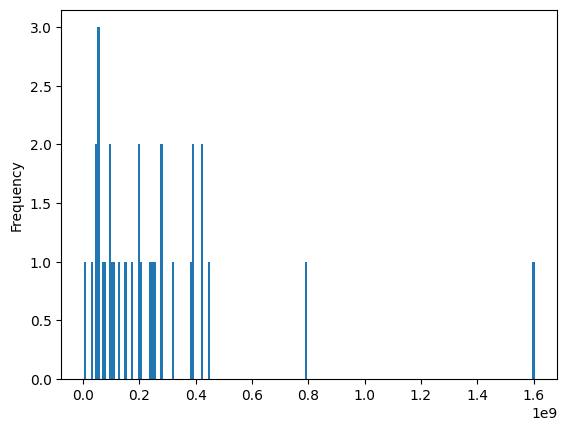

In [40]:
pluto_ogrio["shape_area"].plot.hist(bins=200)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'shape_area'}, xlabel='school_dis'>

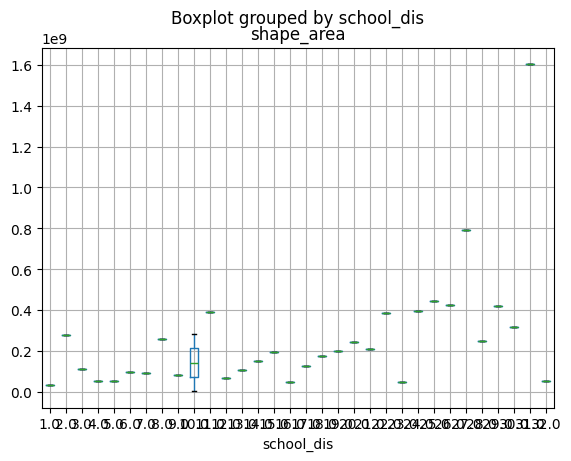

In [36]:
pluto_ogrio.boxplot(column="shape_area", by="school_dis")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [17]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors", "ResArea"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors", "ResArea"]])

In [18]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
2,3.0,20.000000,11.269428,13.0,13.50,14.0,23.50,33.0
4,36.0,18.847222,11.479684,0.0,13.75,17.5,24.25,46.0
3,8637.0,9.823289,7.125113,0.0,6.00,6.0,13.00,82.0
1,882.0,23.705215,15.775916,0.0,13.00,20.0,33.00,98.0
0,847261.0,2.258462,1.499874,0.0,2.00,2.0,2.50,104.0


<Axes: xlabel='NumFloors', ylabel='ResArea'>

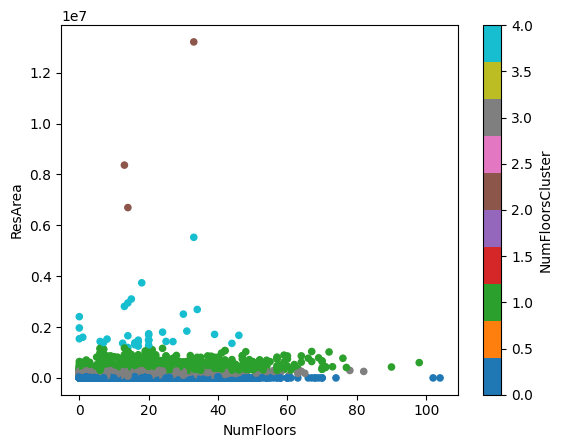

In [19]:
pluto_ogrio.plot.scatter(x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10")

KeyError: 'Shape_Leng'

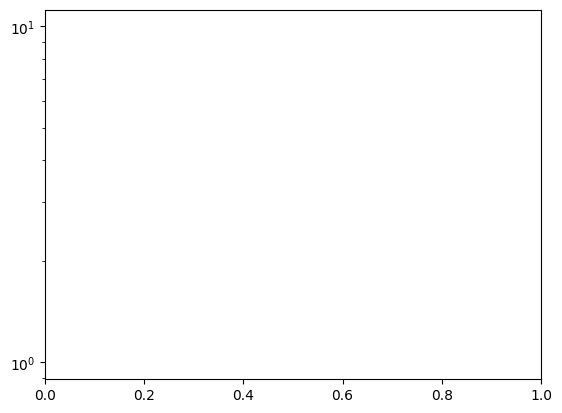

In [41]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="Shape_Leng", y="Shape_Area", c="SchoolDist", cmap="tab10", logy=True
)

In [44]:
pluto_ogrio["Shape_Area"].plot.hist(bins=5, alpha=0.5)

KeyError: 'Shape_Area'

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC School District')

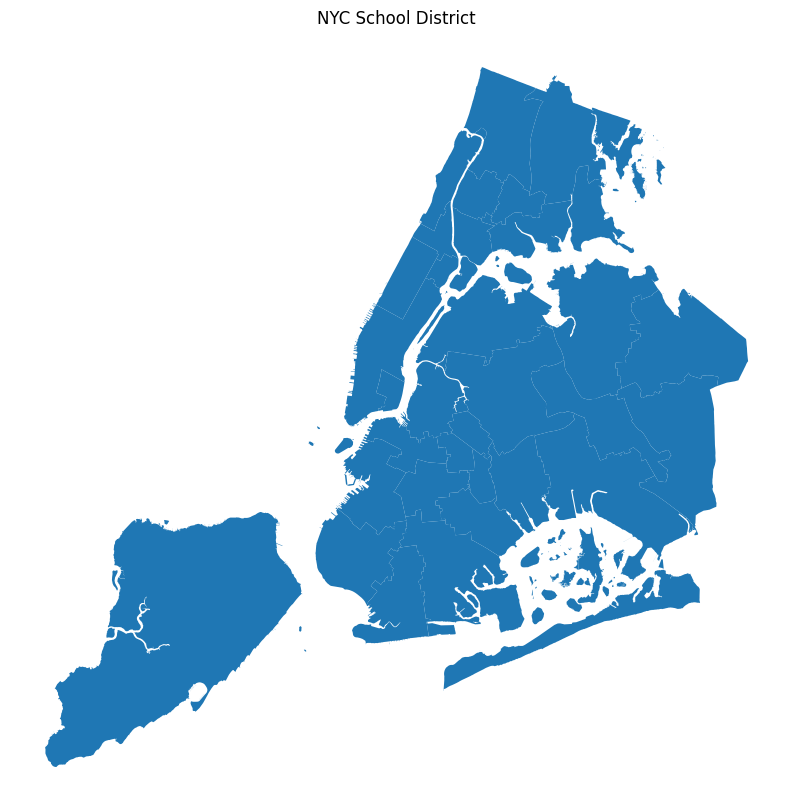

In [46]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC School District")

In [54]:
cmap = {
    "MULTIPOLYGON": "#ff0000",
    "POLYGON": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [55]:
pluto_ogrio.fillna({"geometry": "Unknown"}, inplace=True)

In [62]:
pluto_ogrio["color"] = pluto_ogrio["LandUse"].map(cmap)

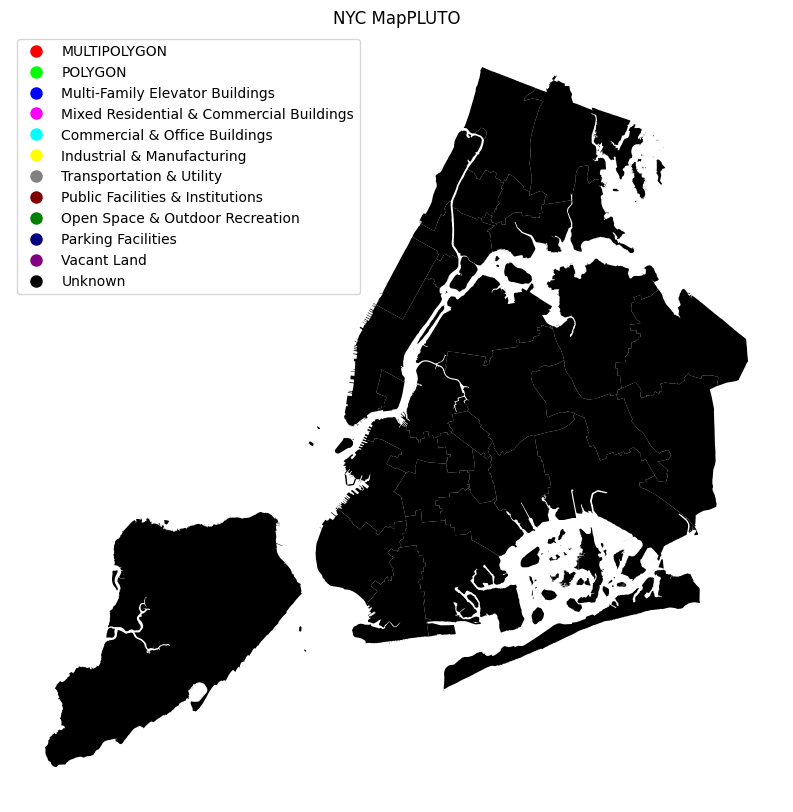

In [63]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

Text(0.5, 1.0, 'NYC MapPLUTO')

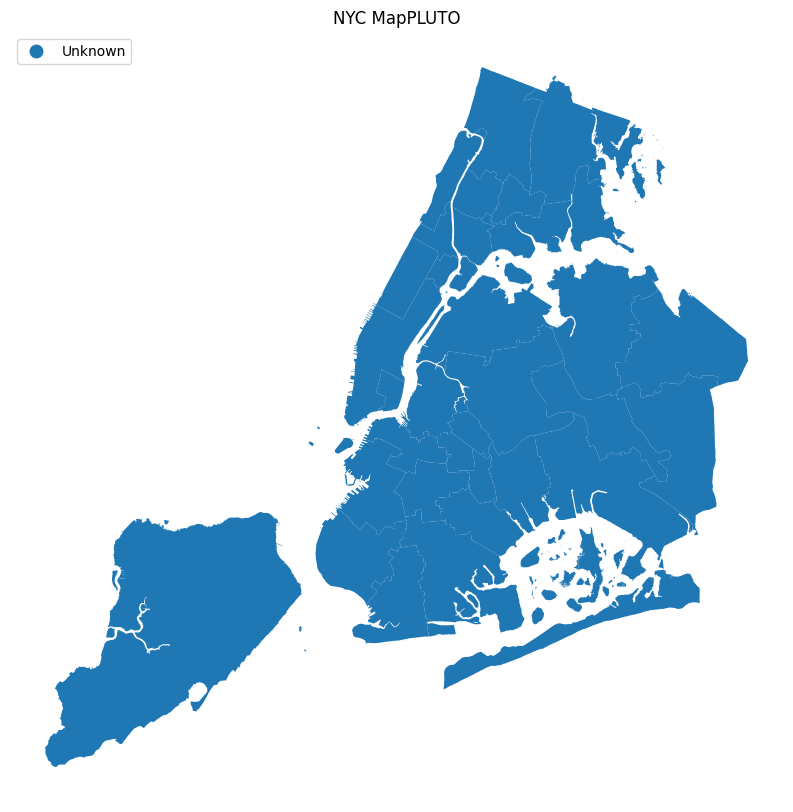

In [60]:
pluto_ogrio.plot(
    column="LandUse", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


In [28]:
pluto_ogrio.Borough

0         MN
1         MN
2         MN
3         MN
4         MN
          ..
856814    SI
856815    SI
856816    SI
856817    SI
856818    SI
Name: Borough, Length: 856819, dtype: object

# prep for interactive mapping


In [69]:
pluto_ogrio[pluto_ogrio.Borough.eq('MN')].plot(column="LandUse", figsize=(10,10))

AttributeError: 'GeoDataFrame' object has no attribute 'Borough'

In [30]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [70]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [71]:
cmap_rgb

{'MULTIPOLYGON': [255, 0, 0],
 'POLYGON': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [72]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

NameError: name 'pluto_ogrio_wgs' is not defined

In [34]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

C:\Users\cathe\AppData\Local\Temp\ipykernel_30084\961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [35]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x000002121A759AE0>
[
  [
  …

In [36]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [37]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x000002121A75A0E0>
[
  [
  …

In [38]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color


## visualize a continuous variable


In [39]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x000002121A75B3A0>
[
  [
  …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


In [40]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    # Select only a few attribute columns from the table
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
    extruded=True,
    get_elevation=pluto_ogrio_wgs["NumFloors"] * 14,
)
m = Map(layer)
m

Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x000002121A75ABC0>
[
…

# save data


In [41]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [42]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")